# Real Estate Modelling
## An exploratory investigation into data science techniques
---

The following context has been provided by the Microsoft Learn platform, the repository for which can be found <a href="https://github.com/MicrosoftDocs">here</a>.

In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Section 1: exploratory data analysis
We begin by importing and analysing the dataset, looking to identify features that contribute meaningfully to the sale price of a plot of land.

In [2]:
# !wget https://raw.githubusercontent.com/MicrosoftDocs/ml-basics/master/challenges/data/real_estate.csv
house_data = pd.read_csv('https://raw.githubusercontent.com/MicrosoftDocs/ml-basics/master/challenges/data/real_estate.csv')
house_data.head()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


<ipython-input-3-14395a41c164>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


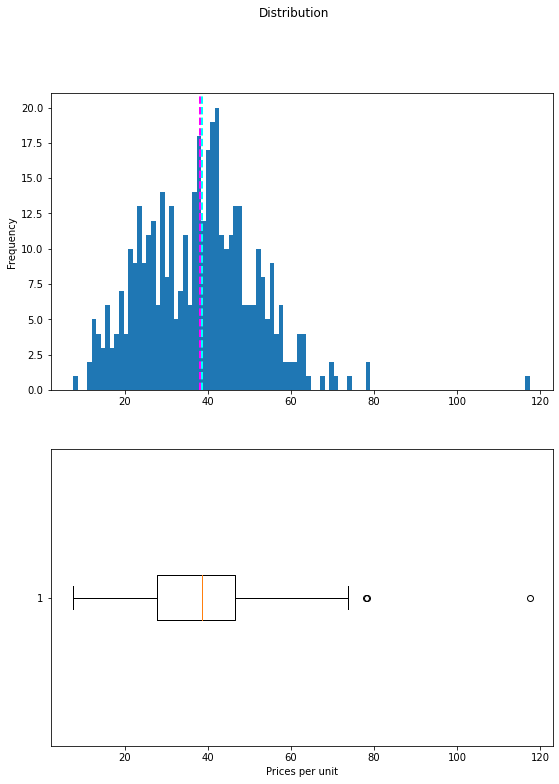

In [3]:
# Get the price_per_unit column
prices = house_data['price_per_unit']


# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(prices, bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(prices.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(prices.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(prices, vert=False)
ax[1].set_xlabel('Prices per unit')

# Add a title to the Figure
fig.suptitle('Distribution')

# Show the figure
fig.show()

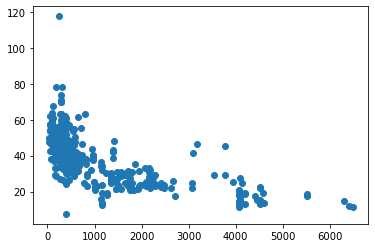

In [4]:
plt.scatter(house_data.transit_distance, house_data.price_per_unit)
plt.show()

We now conduct some simple visual exploration of the features of our dataset. I have decided to split our features into continous and categorical subsets. We begin by exploring the continuous data:

In [5]:
numeric_features = ['house_age', 'transit_distance', 'latitude', 'longitude']

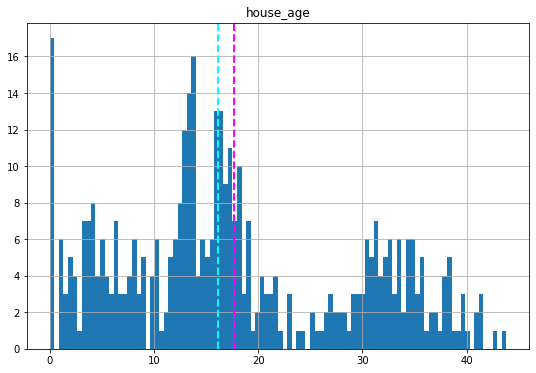

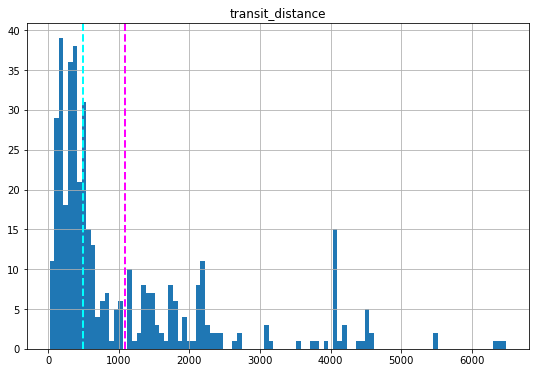

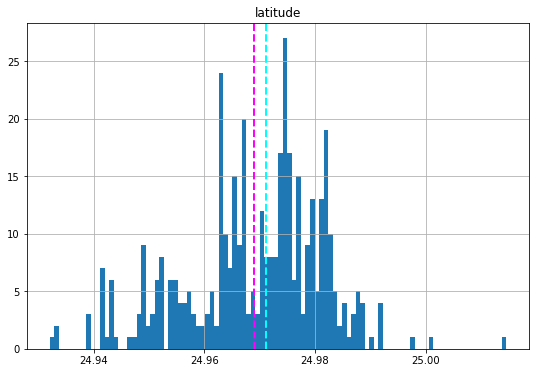

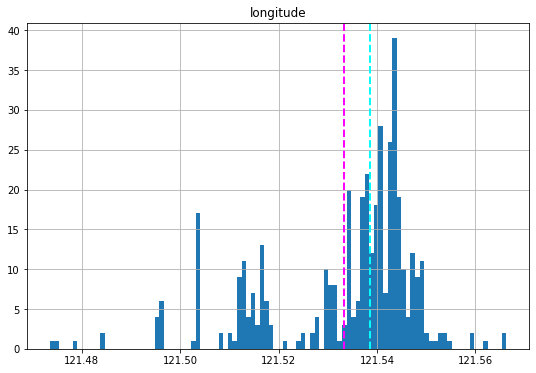

In [6]:
# Plot a histogram for each feature
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = house_data[col]
    feature.hist(bins=100, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

We now explore the correlations, if any, between these continuous features and the sale price of each property:

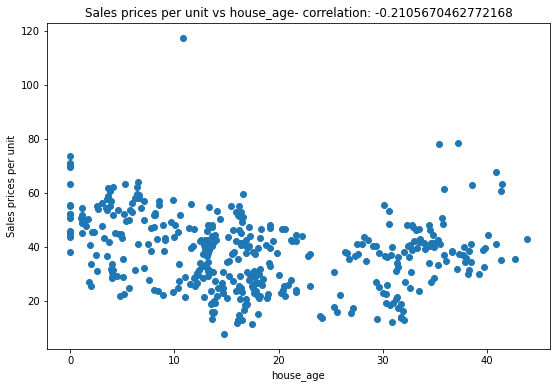

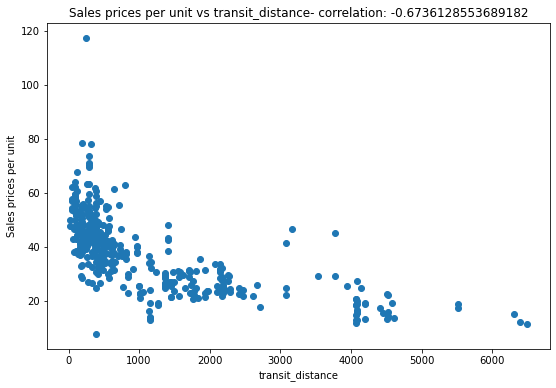

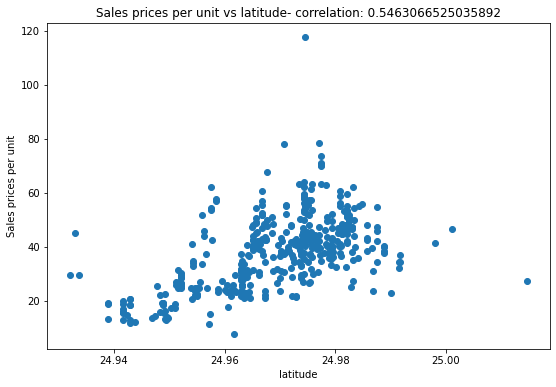

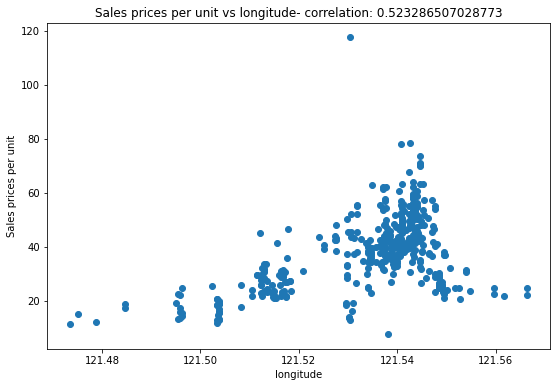

In [7]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = house_data[col]
    label = prices
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Sales prices per unit')
    ax.set_title('Sales prices per unit vs ' + col + '- correlation: ' + str(correlation))
plt.show()


Out of interest, I also looked at the joint correlation between the langitude/longitude and the sales prices per unit:

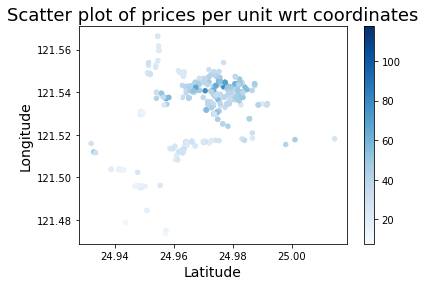

In [8]:
plt.scatter(house_data['latitude'], house_data['longitude'], c=prices, cmap="Blues", s=20)
plt.colorbar()
plt.xlabel("Latitude", fontsize="14")
plt.ylabel("Longitude", fontsize="14")
plt.title("Scatter plot of prices per unit wrt coordinates", fontsize="18")
plt.show()

Now for the categorical features:

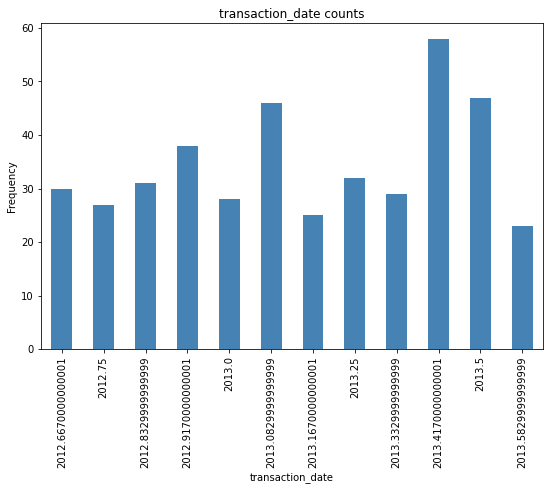

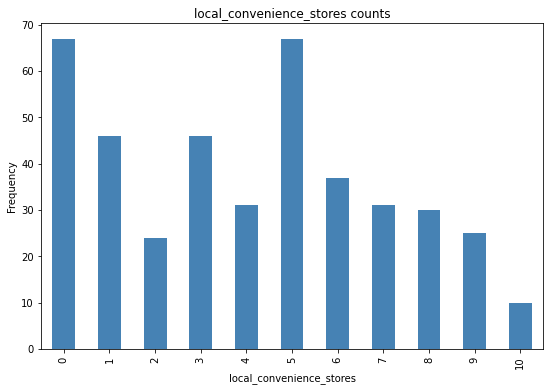

In [9]:
categorical_features = ['transaction_date', 'local_convenience_stores']
for col in categorical_features:
    counts = house_data[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()

Similar to the previous data, let us look at some boxplots connecting our categorical data to the sales prices per unit:

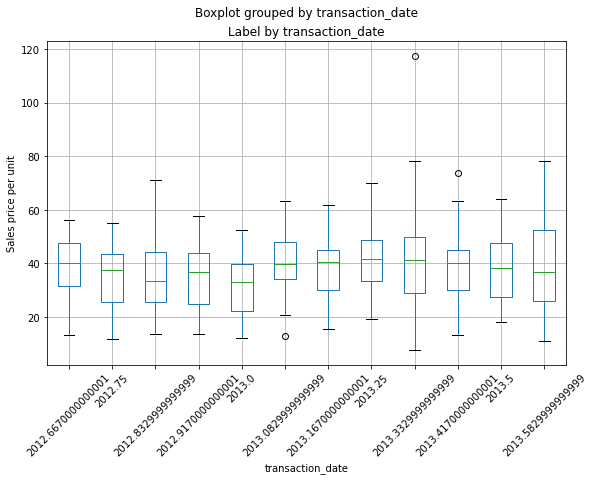

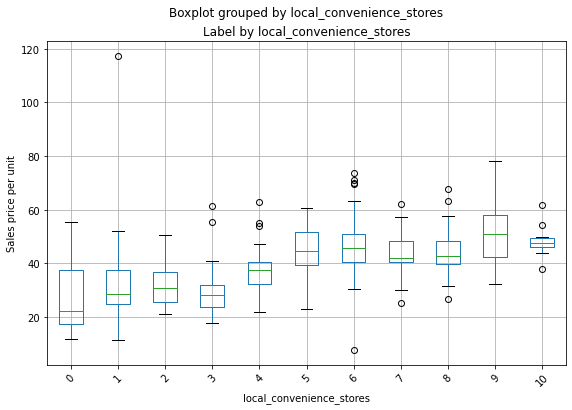

In [10]:
# plot a boxplot for the label by each categorical feature
for col in categorical_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    house_data.boxplot(column = 'price_per_unit', by = col, ax = ax, rot=45)
    ax.set_title('Label by ' + col)
    ax.set_xlabel(col)
    ax.set_ylabel("Sales price per unit")
plt.show()

## Section 2: modelling

### (i) Linear Regression model

In [19]:
# the '.values' removes the labels for each column 
X, y = house_data[['transaction_date', 'house_age', 'transit_distance', 'local_convenience_stores', 'latitude', 'longitude']].values, house_data['price_per_unit'].values
print('Features:', X[:10], '\nPrices', y[:10], sep='\n')

Features:
[[2.0129170e+03 3.2000000e+01 8.4878820e+01 1.0000000e+01 2.4982980e+01
  1.2154024e+02]
 [2.0129170e+03 1.9500000e+01 3.0659470e+02 9.0000000e+00 2.4980340e+01
  1.2153951e+02]
 [2.0135830e+03 1.3300000e+01 5.6198450e+02 5.0000000e+00 2.4987460e+01
  1.2154391e+02]
 [2.0135000e+03 1.3300000e+01 5.6198450e+02 5.0000000e+00 2.4987460e+01
  1.2154391e+02]
 [2.0128330e+03 5.0000000e+00 3.9056840e+02 5.0000000e+00 2.4979370e+01
  1.2154245e+02]
 [2.0126670e+03 7.1000000e+00 2.1750300e+03 3.0000000e+00 2.4963050e+01
  1.2151254e+02]
 [2.0126670e+03 3.4500000e+01 6.2347310e+02 7.0000000e+00 2.4979330e+01
  1.2153642e+02]
 [2.0134170e+03 2.0300000e+01 2.8760250e+02 6.0000000e+00 2.4980420e+01
  1.2154228e+02]
 [2.0135000e+03 3.1700000e+01 5.5120380e+03 1.0000000e+00 2.4950950e+01
  1.2148458e+02]
 [2.0134170e+03 1.7900000e+01 1.7831800e+03 3.0000000e+00 2.4967310e+01
  1.2151486e+02]]

Prices
[37.9 42.2 47.3 54.8 43.1 32.1 40.3 46.7 18.8 22.1]


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
model = LinearRegression().fit(X_train, y_train)
print(model)

LinearRegression()


In [27]:
predictions = model.predict(X_test)

print('Predicted labels: ', np.round(predictions, 1)[:10])
print('Actual labels   : ', y_test[:10])

Predicted labels:  [44.9 12.8 44.9 34.9 47.7 45.8 29.9 34.6 44.  46.1]
Actual labels   :  [38.2 15.6 42.  30.8 54.4 40.8 27.7 30.5 48.  42. ]


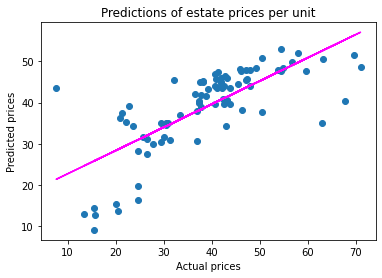

In [28]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual prices')
plt.ylabel('Predicted prices')
plt.title('Predictions of estate prices per unit')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [30]:
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 79.66000166529479
RMSE: 8.925245187965134
R2: 0.5412615965734933


Now to compare this with the two records provided in the challenge brief:

In [32]:
new_X = np.array([[2013.167, 16.2, 289.3248, 5, 24.98203, 121.54348], [2013.000, 13.6, 4082.015, 0, 24.94155, 121.50381]])

new_predictions = model.predict(new_X)
print("Predictions: ", new_predictions)

Predictions:  [45.82950263 14.48656713]


### (ii) Decision Tree model